In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt

import os
import glob

from sklearn.model_selection import train_test_split

In [2]:
data_dir = './AI量化模型预测挑战赛公开数据/' 

### Functions for Data Preprocessing

In [3]:
def log_return(prices: pd.Series)-> pd.Series:
    return np.log(prices).diff()

def get_wap1(df: pd.DataFrame)->pd.Series:
    wap1 = (df['n_bid1'] * df['n_asize1'] + df['n_ask1'] *
            df['n_bsize1']) / (df['n_bsize1'] + df['n_asize1'])
    return wap1

def get_wap1(df: pd.DataFrame) -> pd.DataFrame:
    wap2 = (df['n_bid2'] * df['n_asize2'] +
            df['n_ask2'] * df['n_bsize2']) / (df['n_bsize2'] + df['n_asize2'])
    return wap2

def realised_volatility(series: pd.Series) -> pd.Series:
    return np.sqrt(np.sum(series ** 2))

def count_unique(series: pd.Series) -> int:
    return len(np.unique(series))

In [4]:
data = pd.read_csv('input_sample.csv')
data.index.name = 'index'
display(data.head())
display(data.columns)

,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,n_bsize2,...,n_asize3,n_ask4,n_asize4,n_ask5,n_asize5,label_5,label_10,label_20,label_40,label_60
index,,,,,,,,,,,,,,,,,,,,,
0,0,09:40:03,0,0.015691,2594895.0,0.015270,0.01513,1.961524e-06,0.01485,9.973850e-07,...,0.000010,0.016251,0.000005,0.016531,0.000016,1,0,0,0,0
1,0,09:40:06,0,0.015410,837314.0,0.015410,0.01513,3.424355e-06,0.01485,1.030631e-06,...,0.000005,0.016531,0.000016,0.016811,0.000018,0,0,0,0,0
2,0,09:40:09,0,0.015130,184807.0,0.015270,0.01513,3.158386e-06,0.01485,9.807620e-07,...,0.000011,0.016251,0.000005,0.016531,0.000017,1,0,0,0,0
3,0,09:40:12,0,0.015691,500046.0,0.015551,0.01541,4.155771e-07,0.01513,2.044639e-06,...,0.000005,0.016531,0.000016,0.016811,0.000018,0,0,0,0,0
4,0,09:40:15,0,0.014290,1785635.0,0.014710,0.01429,9.308927e-06,0.01401,4.986925e-08,...,0.000036,0.015971,0.000009,0.016251,0.000005,1,0,0,0,0


Index(['date', 'time', 'sym', 'n_close', 'amount_delta', 'n_midprice',
       'n_bid1', 'n_bsize1', 'n_bid2', 'n_bsize2', 'n_bid3', 'n_bsize3',
       'n_bid4', 'n_bsize4', 'n_bid5', 'n_bsize5', 'n_ask1', 'n_asize1',
       'n_ask2', 'n_asize2', 'n_ask3', 'n_asize3', 'n_ask4', 'n_asize4',
       'n_ask5', 'n_asize5', 'label_5', 'label_10', 'label_20', 'label_40',
       'label_60'],
      dtype='object')

In [6]:
features = data.columns.to_list() # 先简单地将所有的列都当作特征。

## 模型构建部份

In [5]:
def calc_model_importance(model,
                         feature_names=None,
                         importance_type='gain')->pd.DataFrame:
    '''给定模型,特征名称,重要性的计算方式,返回重要性df'''
    importance_df = pd.DataFrame(
        model.feature_importance(importance_type=importance_type),
        index=feature_names,
        columns=['importance']).sort_values('importance')
    
    return importance_df

### LGBM

/Users/liangyuchen/miniconda3/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:138: RuntimeWarning: overflow encountered in cast
  return arr.astype(dtype, copy=True)
/Users/liangyuchen/miniconda3/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
[20]	training's multi_logloss: 0.364935	valid_1's multi_logloss: 0.2873
[40]	training's multi_logloss: 0.338017	valid_1's multi_logloss: 0.292293
[60]	training's multi_logloss: 0.316965	valid_1's multi_logloss: 0.297755
Early stopping, best iteration is:
[20]	training's multi_logloss: 0.364935	valid_1's multi_logloss: 0.2873
Evaluated only: multi_logloss
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

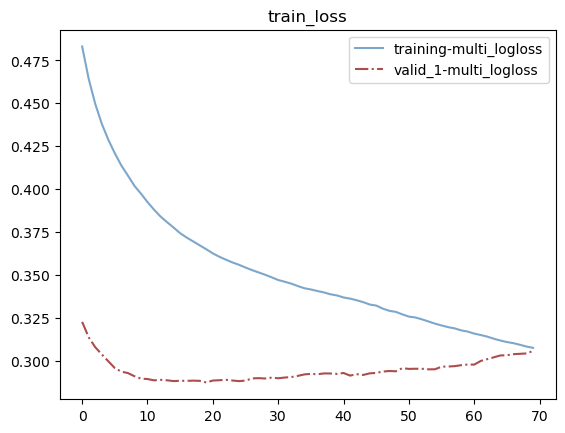

In [24]:
params = {
    'learning_rate': 0.1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.8,
    'max_depth': 4,
    'n_jobs': 4,
    'objective': 'multiclass',  # 目标函数
    'num_class': 3,
    'verbose': -1,
}
label_list = ['label_5', 'label_10', 'label_20', 'label_40', 'label_60']
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=label_list+['date','time','sym']).astype(float16),
    data['label_5'],
    test_size=0.3,
    shuffle=False, # 避免利用未来的数据
    )

# 转换为Dataset数据格式
train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test)

# 模型训练
eval_result = {}
gbm = lgb.train(params, train_data, valid_sets=[train_data, validation_data],
                verbose_eval=20,
          callbacks=[lgb.log_evaluation, lgb.early_stopping(50, first_metric_only=True), lgb.record_evaluation(eval_result)])

# 模型预测
y_pred = gbm.predict(X_test)
y_pred = [list(x).index(max(x)) for x in y_pred]
print(y_pred)

# 模型评估

def print_loss(evals_result):
    plt.title('train_loss')
    for data_name, metric_res in eval_result.items():
        for metric_name, log_ in metric_res.items():
            plt.plot(log_, label = f'{data_name}-{metric_name}', 
                    color='steelblue' if 'train' in data_name else 'darkred', 
                    linestyle=None if 'train' in data_name else '-.',
                    alpha=0.7)
    plt.legend()
    plt.show()


print_loss(eval_result)